# Kaggle Challenge: House price regression

In [13]:
#pip install scikit-learn --upgrade

In [14]:
pip install tqdm

Note: you may need to restart the kernel to use updated packages.


#### Importing modules

In [15]:
# data wrangling
import pandas as pd
import numpy as np


#visualization
import seaborn as sns
import matplotlib.pyplot as plt
#from math import pi



#Machine Learning

#Scaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import RobustScaler


# Imputer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder

# Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_transformer
from sklearn.compose import make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline #Note that make_pipeline is just a slightly more concise function than Pipeline, as it does not require you to name each step, but their behaviour is equivalent.
from sklearn import set_config


#Supervised Machine Learning

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV



#Regression
from sklearn.tree import DecisionTreeRegressor 
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import ElasticNet, ElasticNetCV
from sklearn.linear_model import RidgeCV


#Feature selection
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import RFECV
from sklearn.decomposition import PCA

#Metrics
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error


from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_log_error






In [16]:
pd.set_option('display.max_columns', 100)

# 1. Preparing the data

#### Importing data

In [17]:
path = 'path_to/your_data/train.csv'
data = pd.read_csv(path).set_index('Id')

#### Exploring the data

In [18]:
#data.sample(10)
#data.info()
#data.describe()
#data.corr()
#data

#### Categorical features

In [19]:
# Categorical features

cat_cols = ['BsmtQual', 'BsmtCond','ExterQual','ExterCond','HeatingQC','KitchenQual','FireplaceQu','GarageQual','GarageCond']

for col in cat_cols:
    data[col]=data[col].astype('category')

#### Numerical features

In [20]:
# List with numeric features

# Simple way to reduce the number of numeric columns
#num_cols = data.corrwith(y).abs().sort_values(ascending=False).head(15).keys().to_list()

num_cols = data.select_dtypes('number').columns.to_list()

#### Object features

In [21]:
#obj_cols = data.select_dtypes('object').columns.to_list()



# Object features

obj_cols = ['MSZoning', 'Condition1', 'Heating', 
            #'Street', 
            'CentralAir',
       'Foundation', 'BsmtExposure', 'BsmtFinType1',
       'LotShape', 'LandContour', 
            #'Utilities', 
            'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'BsmtFinType2',
       'Electrical', 'Functional', 'GarageType', 'GarageFinish', 'PavedDrive',
       'SaleType', 'SaleCondition']



In [22]:
# Columns selected for analysis

select_cols = []
select_cols = num_cols + cat_cols + obj_cols

In [23]:
data = data[select_cols]

In [24]:
X = data.copy()
y = X.pop('SalePrice')

X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=.8, random_state=8)

#### Colinearity

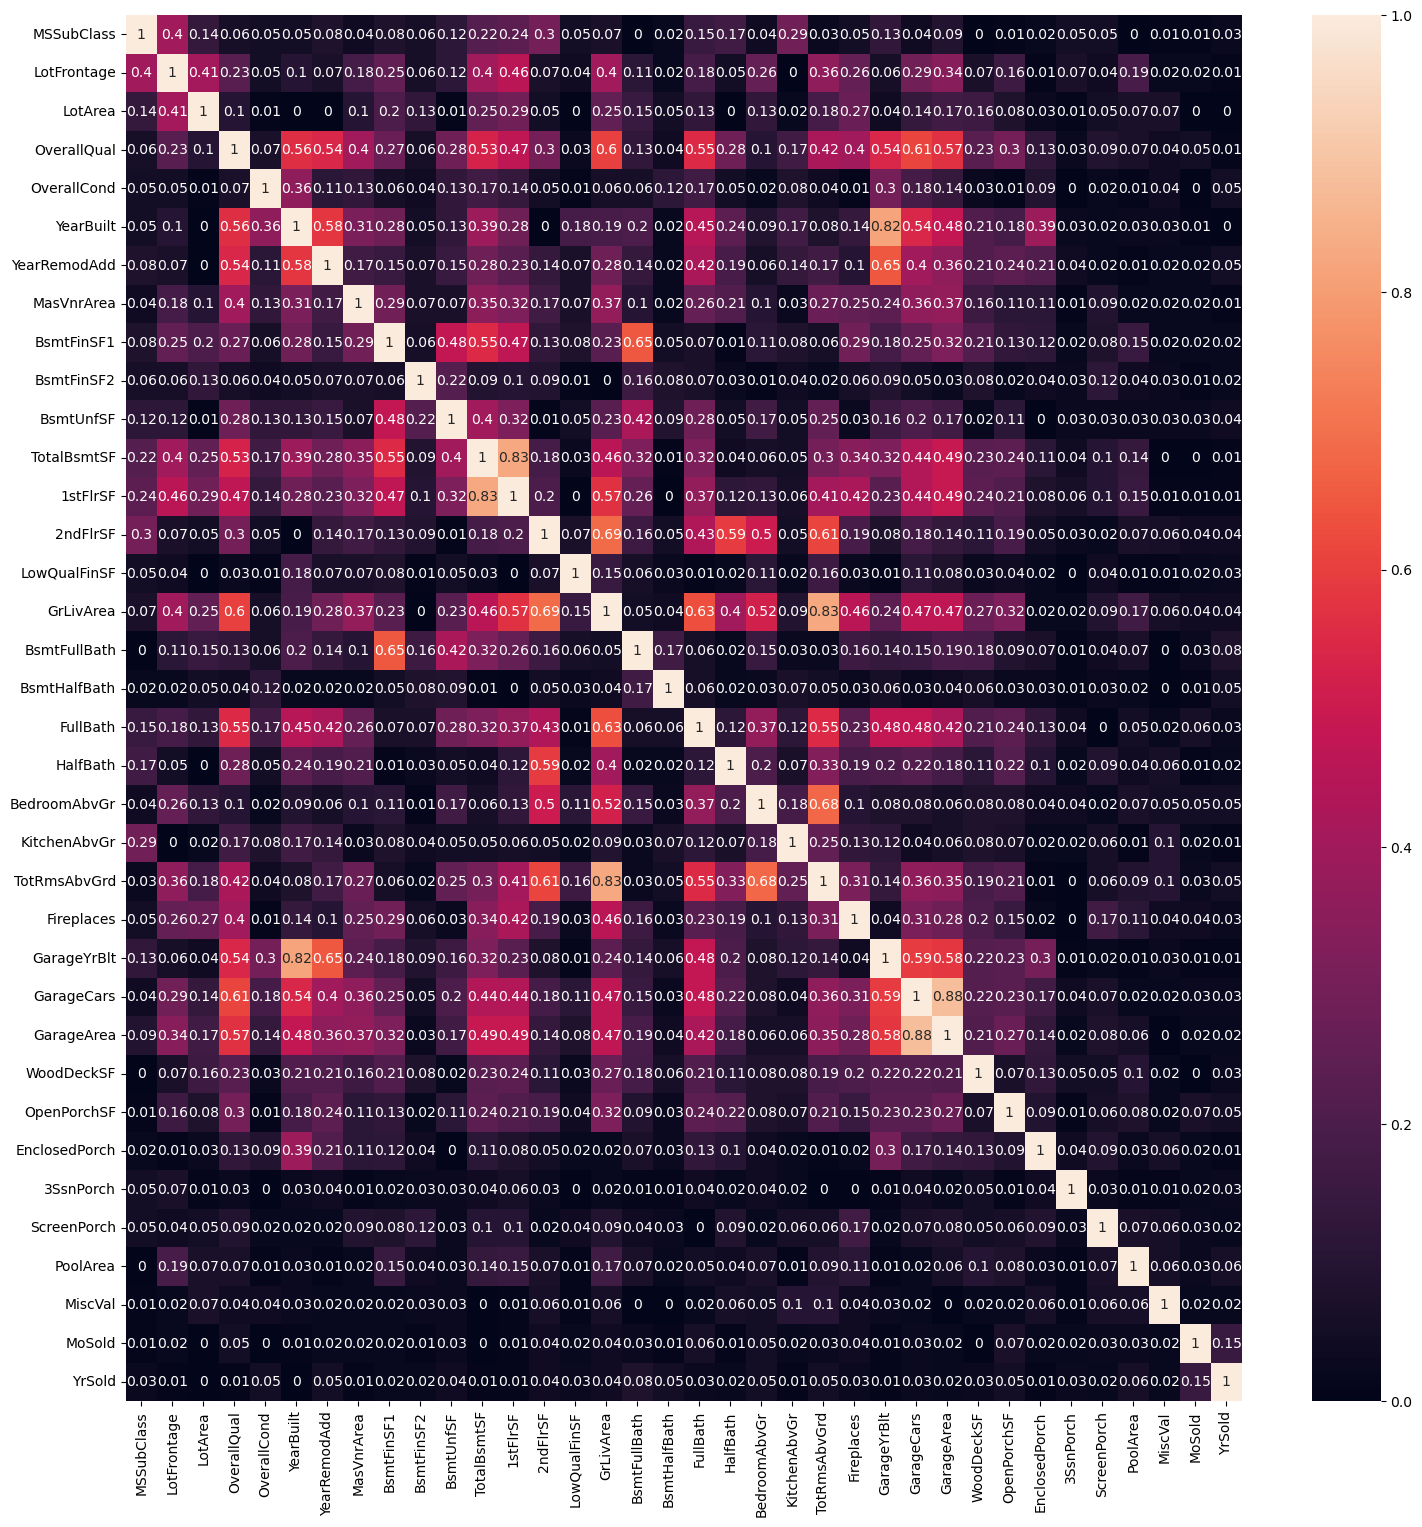

In [25]:
corrMatrix = data.corr().abs()
corrMatrix

corrMatrix = round(X_train.corr().abs(),2)
# Plot a heatmap of the correlation matrix.
fig, ax = plt.subplots(figsize=(18,18))
sns.heatmap(corrMatrix, annot=True);

In [26]:
# Drop highly collinear factors (if any)

# Select upper triangle of correlation matrix
upper = corrMatrix.where(np.triu(np.ones(corrMatrix.shape), k=1).astype('bool'))

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

# Drop the columns from the train set.
data = data.drop(columns=to_drop)

# 2. Pipeline: Imputation, scaling, feature Selection

In [27]:
# Numeric pipe

numeric_pipe = make_pipeline(
    SimpleImputer(strategy="mean")) 

# Categoric pipe for non-ordinal features

quality = ['NA','Po','Fa','TA','Gd','Ex'] #for cat_cols

categoric_ordinal_pipe = make_pipeline(
    (SimpleImputer(strategy="constant", fill_value="-1")),
    (OrdinalEncoder(categories=[quality]*len(cat_cols), handle_unknown='use_encoded_value', unknown_value=-1))
    )



categoric_onehot_pipe = make_pipeline(
            (SimpleImputer(strategy="constant", fill_value="0")),
            (OneHotEncoder(handle_unknown='ignore', sparse_output=False) 
            )
)

# Defining the preprocessor

preprocessor = make_column_transformer(
        (numeric_pipe,make_column_selector(dtype_include='number')), 
        (categoric_ordinal_pipe, make_column_selector(dtype_include='category')),
       (categoric_onehot_pipe, make_column_selector(dtype_include='object'))
)

# Feature selection

feature_selection = SelectKBest(score_func=f_regression, k=23)
#SelectFromModel(DecisionTreeRegressor(max_features=34))


# PCA
pca = PCA()

scaler = StandardScaler()
# RobustScaler()
#MinMax()


# Defining the full pipeline

full_pipeline = make_pipeline(preprocessor, 
                              scaler,
                              feature_selection,                            
                              pca,
                              RandomForestRegressor()).set_output(transform='pandas')

full_pipeline

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f997e74cdc0>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='-1',
                                                                                 strategy='constant')),
                                                                  ('ordinalencoder',
                                                                   OrdinalEncoder(c...
                                                                                 strategy='constant')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f997e74b190>)])),
                ('standardscaler', StandardScaler()),
                ('selectkbest',
                 SelectKBest(k=23,
                             score_func=<function f_regression at 0x7f9980a85c10>)),
                ('pca', PCA()),
                ('randomforestregressor', RandomForestRegressor())])

# 3. Model selection and specification

#### RandomForestRegressor

In [28]:

param_grid = {
   'columntransformer__pipeline-1__simpleimputer__strategy': ['median','mean'],
   'selectkbest__k': range(20,30,2),
   'pca__n_components': range(6,12,2),
    'randomforestregressor__min_samples_split': range(1,3),
    'randomforestregressor__max_depth': range(10,15),
    'randomforestregressor__min_samples_leaf': range(1,3)

    
}


rf_search = GridSearchCV(full_pipeline,
             param_grid=param_grid,
             cv=5,
            scoring="neg_mean_squared_log_error",
             verbose=1)

rf_search.fit(X_train,y_train)
rf_search.best_params_

Fitting 5 folds for each of 600 candidates, totalling 3000 fits


{'columntransformer__pipeline-1__simpleimputer__strategy': 'mean',
 'pca__n_components': 10,
 'randomforestregressor__max_depth': 14,
 'randomforestregressor__min_samples_leaf': 2,
 'randomforestregressor__min_samples_split': 1,
 'selectkbest__k': 22}

In [30]:
rf_predict = rf_search.best_estimator_.predict(X_test)

# Scores
rf_msle = mean_squared_log_error(y_test, rf_predict)
rf_mae = mean_absolute_error(y_true = y_test, y_pred = rf_predict)
rf_rmse = mean_squared_error(y_true = y_test, y_pred = rf_predict, squared=False)
rf_mape = mean_absolute_percentage_error(y_true = y_test, y_pred = rf_predict)
rf_r2 = r2_score(y_true = y_test, y_pred = rf_predict)

#### Decision Tree Regressor

In [31]:
dt_pipeline = make_pipeline(preprocessor,
                              scaler,
                              feature_selection,
                              pca,
                              DecisionTreeRegressor()).set_output(transform='pandas')

param_grid = {
    'columntransformer__pipeline-1__simpleimputer__strategy': ['median','mean'],
    'selectkbest__k': range(21,26),
    'pca__n_components': range(6,12,2),
    'decisiontreeregressor__max_depth': range(12,18),
    'decisiontreeregressor__min_samples_leaf': range(4,12,2)
   
    
}

dt_search = GridSearchCV(dt_pipeline,
             param_grid=param_grid,
             cv=5,
            scoring="neg_mean_squared_log_error",
             verbose=1)

dt_search.fit(X_train,y_train)
dt_search.best_params_

Fitting 5 folds for each of 720 candidates, totalling 3600 fits


{'columntransformer__pipeline-1__simpleimputer__strategy': 'mean',
 'decisiontreeregressor__max_depth': 14,
 'decisiontreeregressor__min_samples_leaf': 10,
 'pca__n_components': 6,
 'selectkbest__k': 23}

In [33]:
# Pipeline with best model specifications 


best_dt_predict= dt_search.best_estimator_.predict(X_test)

dt_msle = mean_squared_log_error(y_test, best_dt_predict)
dt_mae = mean_absolute_error(y_true = y_test, y_pred = best_dt_predict)
dt_rmse = mean_squared_error(y_true = y_test, y_pred = best_dt_predict, squared=False)
dt_mape = mean_absolute_percentage_error(y_true = y_test, y_pred = best_dt_predict)
dt_r2 = r2_score(y_true = y_test, y_pred = best_dt_predict)

#### KNeigborRegressor

In [34]:
# 

knn_pipeline = make_pipeline(preprocessor, 
                              feature_selection,
                              PCA(),
                              KNeighborsRegressor())

param_grid = {
    'columntransformer__pipeline-1__simpleimputer__strategy': ['median','mean'],
    'pca__n_components': range(5, 20, 2),
    'kneighborsregressor__n_neighbors': range(2,12,2),
    'kneighborsregressor__weights': ['uniform','distance'],
    'kneighborsregressor__leaf_size': range(20,40,2)
 
    
}


knn_search = GridSearchCV(knn_pipeline,
             param_grid=param_grid,
             cv=5,
            scoring="neg_mean_squared_log_error",
             verbose=1)

knn_search.fit(X_train,y_train)
knn_search.best_params_

Fitting 5 folds for each of 1600 candidates, totalling 8000 fits


{'columntransformer__pipeline-1__simpleimputer__strategy': 'mean',
 'kneighborsregressor__leaf_size': 34,
 'kneighborsregressor__n_neighbors': 10,
 'kneighborsregressor__weights': 'distance',
 'pca__n_components': 15}

In [37]:
knn_predict = knn_search.best_estimator_.predict(X_test)

knn_msle = mean_squared_log_error(y_test, knn_predict)
knn_mae = mean_absolute_error(y_true = y_test, y_pred = knn_predict)
knn_rmse = mean_squared_error(y_true = y_test, y_pred = knn_predict, squared=False)
knn_mape = mean_absolute_percentage_error(y_true = y_test, y_pred = knn_predict)
knn_r2 = r2_score(y_true = y_test, y_pred = knn_predict)

# 4. Scores

In [38]:
pd.DataFrame({"MSLE": [dt_msle, rf_msle,knn_msle],
              "MAE": [dt_mae, rf_mae,knn_mae],
              "RMSE": [dt_rmse, rf_rmse, knn_rmse],
              "MAPE": [dt_mape, rf_mape, knn_mape],
              "R2": [dt_r2, rf_r2, knn_r2]},
             index=["decision_tree",'random_forest','kneareast'])

,MSLE,MAE,RMSE,MAPE,R2
decision_tree,0.027740,22786.337348,35743.011728,0.125792,0.757221
random_forest,0.024804,20187.744650,35814.735836,0.114079,0.756246
kneareast,0.033971,24416.032771,40036.219253,0.137038,0.695397


#### Loading test data

In [39]:
path = 'path_to/your_data/test.csv'
data_test = pd.read_csv(path)
#data_test = data_test.set_index('Id')
data_test

id_column = data_test.pop('Id')
y_final_predict = rf_search.best_estimator_.predict(data_test)



In [40]:
results = pd.DataFrame({'Id':id_column,'SalePrice':y_final_predict}).set_index('Id')

In [41]:
results.to_csv('choose/destination/results_final.csv')